In [ ]:
import json

# Load the JSON data from a file
with open('output/videoblocks-aerial-view-people-walking-down-center-lane-grocery-shopping-by-produce-sec_ryyqlpbp3__9a31ad8ce3f137b6572eefb5e6255d81__P360_output.json') as f:
    data = json.load(f)


In [14]:
data[:10]

[[{'person': {'BoundingBox': {'Height': 0.13904236257076263,
     'Left': 0.8957214951515198,
     'Top': 0.5057748556137085,
     'Width': 0.0372866615653038},
    'Index': 2},
   'Timestamp': 0}],
 [{'person': {'BoundingBox': {'Height': 0.14474418759346008,
     'Left': 0.8917644619941711,
     'Top': 0.5001097917556763,
     'Width': 0.038100339472293854},
    'Index': 2},
   'Timestamp': 1},
  {'person': {'BoundingBox': {'Height': 0.21943053603172302,
     'Left': 0.4343143403530121,
     'Top': 0.6030677556991577,
     'Width': 0.04674405977129936},
    'Index': 116},
   'Timestamp': 1},
  {'person': {'BoundingBox': {'Height': 0.14461492002010345,
     'Left': 0.9570185542106628,
     'Top': 0.4982215166091919,
     'Width': 0.03411712497472763},
    'Index': 117},
   'Timestamp': 1},
  {'person': {'BoundingBox': {'Height': 0.23990541696548462,
     'Left': 0.5082738995552063,
     'Top': 0.6698524951934814,
     'Width': 0.04250393062829971},
    'Index': 118},
   'Timestamp': 1}

In [20]:
import pandas as pd

# Flatten the JSON structure into a list of records
records = []
for scene in data:
    for entry in scene:
        person = entry.get('person', {})
        bbox = person.get('BoundingBox', {})
        records.append({
            'timestamp': entry.get('Timestamp'),
            'index': person.get('Index'),
            'left': bbox.get('Left'),
            'top': bbox.get('Top'),
            'width': bbox.get('Width'),
            'height': bbox.get('Height')
        })

df = pd.DataFrame(records)


In [21]:
df

,timestamp,index,left,top,width,height
0,0,2,0.895721,0.505775,0.037287,0.139042
1,1,2,0.891764,0.500110,0.038100,0.144744
2,1,116,0.434314,0.603068,0.046744,0.219431
3,1,117,0.957019,0.498222,0.034117,0.144615
4,1,118,0.508274,0.669852,0.042504,0.239905
...,...,...,...,...,...,...
1693,240,118,0.389570,0.681774,0.043212,0.239720
1694,240,203,0.476831,0.302314,0.018298,0.088840
1695,240,223,0.447108,0.382629,0.025589,0.055234
1696,240,216,0.378466,0.614716,0.039587,0.134829


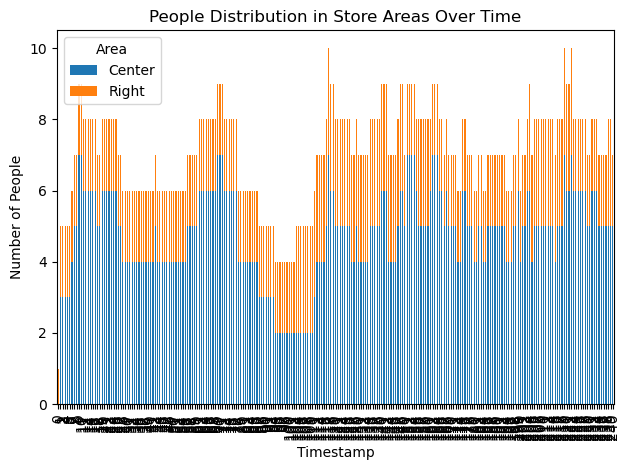

In [46]:
import matplotlib.pyplot as plt

# Assign areas
def assign_area(left):
    if left < 0.33:
        return 'Left'
    elif left < 0.66:
        return 'Center'
    else:
        return 'Right'

df['area'] = df['left'].apply(assign_area)

# Aggregate
area_counts = df.groupby(['timestamp', 'area']).size().unstack(fill_value=0)

# Plot
# area_counts.plot(kind='line', marker='o')
area_counts.plot(kind='bar', stacked=True)
plt.title('People Distribution in Store Areas Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of People')
plt.legend(title='Area')
plt.tight_layout()
plt.show()


In [23]:
# Sort by timestamp for each person
df = df.sort_values(['index', 'timestamp'])

# Build trajectories as lists of (left, top)
trajectories = df.groupby('index').apply(
    lambda x: x[['left', 'top']].values.tolist()
)


In [24]:
#3. Convert Trajectories for Clustering
#To use KMeans, all trajectories must be the same length. We’ll interpolate or truncate to a fixed length (e.g., 10 points).

import numpy as np

def resample_traj(traj, n_points=10):
    traj = np.array(traj)
    idxs = np.linspace(0, len(traj)-1, n_points)
    return np.array([np.interp(idxs, np.arange(len(traj)), traj[:, dim]) for dim in range(2)]).T

# Resample all trajectories
fixed_length = 10
traj_matrix = np.array([resample_traj(traj, fixed_length).flatten() for traj in trajectories])


In [27]:
# 4. Cluster Trajectories
# Now cluster the trajectories (e.g., with KMeans):

from sklearn.cluster import KMeans

n_clusters = 3  # Choose based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(traj_matrix)


In [28]:
labels

array([0, 2, 0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 0],
      dtype=int32)

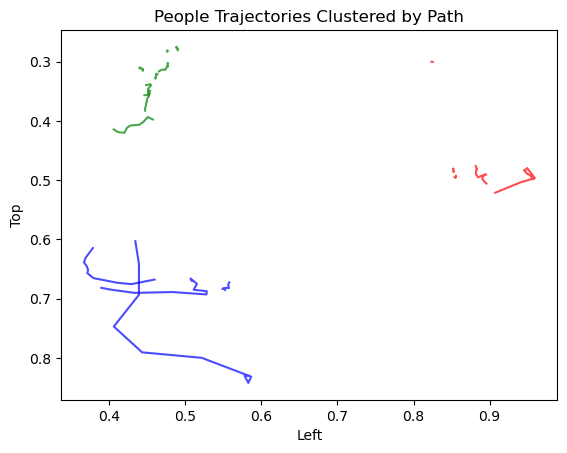

In [29]:
import matplotlib.pyplot as plt

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i, traj in enumerate(trajectories):
    resampled = resample_traj(traj, fixed_length)
    label = labels[i]
    plt.plot(resampled[:, 0], resampled[:, 1], color=colors[label % len(colors)], alpha=0.7)
plt.gca().invert_yaxis()
plt.title('People Trajectories Clustered by Path')
plt.xlabel('Left')
plt.ylabel('Top')
plt.show()


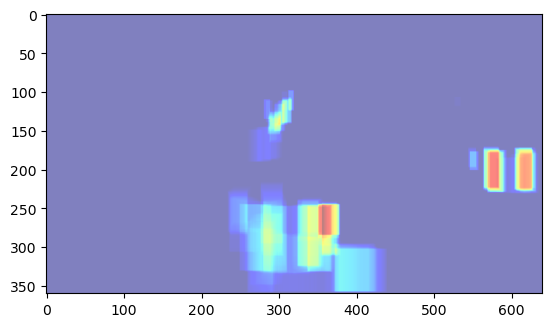

In [36]:
# --- 3. Create a heatmap array ---
heatmap = np.zeros((img_height, img_width), dtype=np.float32)

for scene in data:
    for entry in scene:
        bbox = entry["person"]["BoundingBox"]
        # Convert normalized coordinates to pixel coordinates
        left = int(bbox["Left"] * img_width)
        top = int(bbox["Top"] * img_height)
        width = int(bbox["Width"] * img_width)
        height = int(bbox["Height"] * img_height)
        # Increment heatmap in the bounding box region
        heatmap[top:top+height, left:left+width] += 1

# Optional: Normalize heatmap for better visualization
heatmap = heatmap / heatmap.max()
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # alpha controls transparency


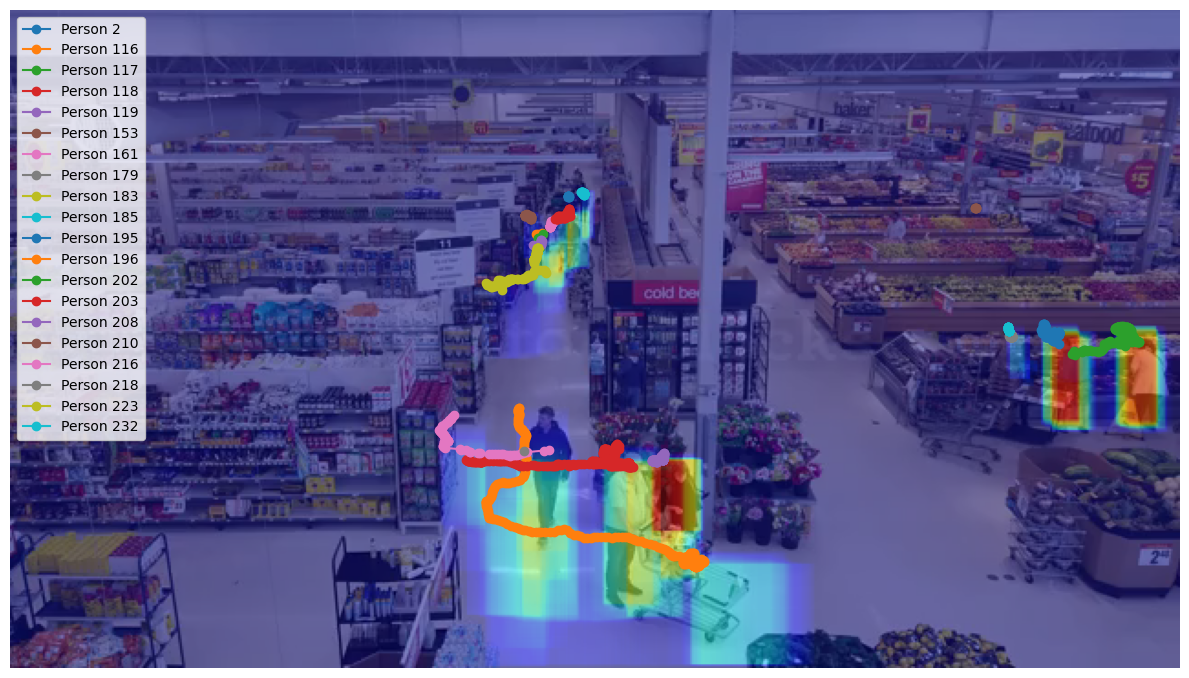

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2

# Replace with your video file path
video_path = 'videoblocks-aerial-view-people-walking-down-center-lane-grocery-shopping-by-produce-sec_ryyqlpbp3__9a31ad8ce3f137b6572eefb5e6255d81__P360.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()
if ret:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # # Display the frame
    # plt.imshow(frame_rgb)
    # plt.axis('off')
    # plt.title('First Frame')
    # plt.show()
else:
    print("Failed to read the video file or no frames found.")

cap.release()


# Load your image
img = frame_rgb
img_height, img_width = img.shape[:2]

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(img)

# Draw bounding boxes and paths
for idx, group in df.groupby('index'):
    xs = group['left'] * img_width
    ys = group['top'] * img_height
    ax.plot(xs, ys, marker='o', label=f'Person {idx}')  # plot path

    
    # Optionally, draw bounding boxes at each timestamp
    # for _, row in group.iterrows():
        # x = row['left'] * img_width
        # y = row['top'] * img_height
        # w = row['width'] * img_width
        # h = row['height'] * img_height
        # rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', alpha=0.3)
        # ax.add_patch(rect)


ax.imshow(heatmap, cmap='jet', alpha=0.5)
ax.set_axis_off()
plt.tight_layout()
plt.legend()
plt.show()
